In [1]:
from tqdm import tqdm
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from pathlib import Path
import os


In [ ]:
project_root = Path.cwd().parent

datasets_dir = project_root / 'datasets'

raw_data_path = datasets_dir / r'Articles_Raw.csv'

try:
    df = pd.read_csv(raw_data_path, encoding = 'utf-8')
except:
    df = pd.read_csv(raw_data_path, encoding = 'latin1')

print(df.info())

df.isnull().sum()

df.describe(include = 'all')

df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Article   2692 non-null   object
 1   Date      2692 non-null   object
 2   Heading   2692 non-null   object
 3   NewsType  2692 non-null   object
dtypes: object(4)
memory usage: 84.2+ KB
None


,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


Helped to choose which field should be used as document content in the IR system...


Text Length Summary.
           char_len   word_count
count   2692.000000  2692.000000
mean    1810.019688   291.274889
std     1080.292897   173.758439
min      216.000000    32.000000
25%     1032.750000   166.000000
50%     1647.500000   263.500000
75%     2325.250000   381.000000
max    19199.000000  3051.000000


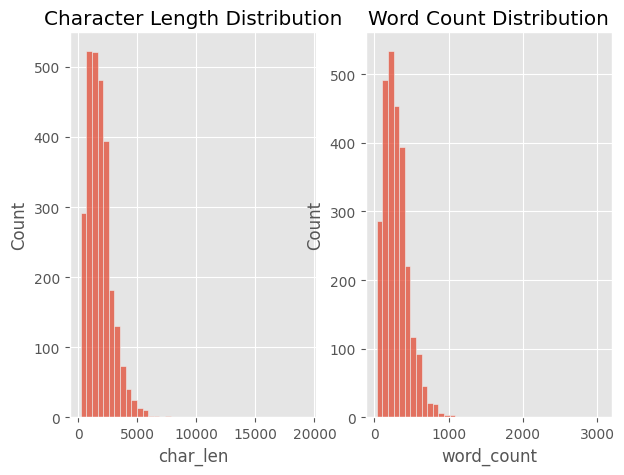

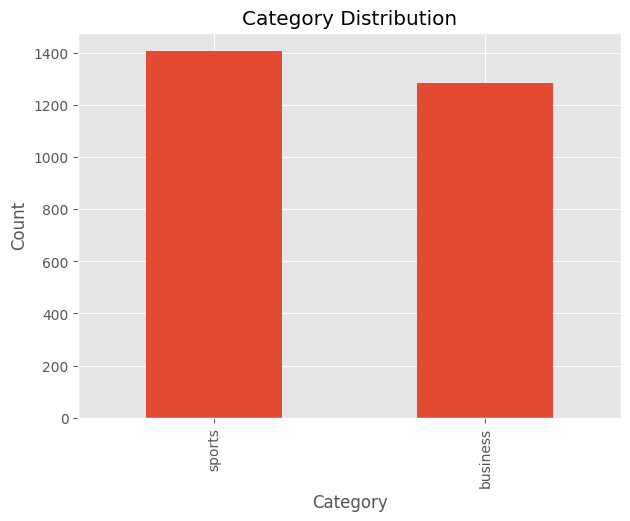


Category Counts
NewsType
sports      1408
business    1284
Name: count, dtype: int64


In [8]:
df['text'] = df['Article'].astype(str)

df['char_len'] = df['Article'].apply(len)

df['word_count'] = df['Article'].apply(lambda x: len(x.split()))

print('\nText Length Summary.')

print(df[['char_len', 'word_count']].describe())

fig, ax = plt.subplots(1,2, figsize = (7,5))
sns.histplot(df['char_len'], bins = 40, ax = ax[0])
ax[0].set_title('Character Length Distribution')

sns.histplot(df['word_count'], bins = 40, ax = ax[1])
ax[1].set_title('Word Count Distribution')

plt.show()

if 'NewsType' in df.columns:

    plt.figure(figsize = (7,5))
    df['NewsType'].value_counts().plot(kind = 'bar')
    plt.title('Category Distribution')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

    print('\nCategory Counts')
    print(df['NewsType'].value_counts())


length of docs will gelp to select approac:
- Very short texts: BM25 might perform well..
- Long texts: dense embeddings or chunking might be needed...

The Category imbalance will show the certain topics dominate:
- if one category overwhelms others, retrieval must avoid bias.
- balanced evaluation samples are needed...

In [9]:

# cleaning hte text lightly...

def simple_cleaning(Article):

    text = Article.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return text

df['clean'] = df['Article'].apply(simple_cleaning)

# unigram frequency ..

vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1,1))
X = vectorizer.fit_transform(df['clean'])
unigrams = vectorizer.get_feature_names_out()
counts = np.asarray(X.sum(axis = 0)).ravel()

# top 20 unigrams..

top_unigrams = pd.DataFrame({'term' : unigrams, 'count' : counts})
top_unigrams = top_unigrams.sort_values(by = 'count', ascending = False).head(20)

print('\nTop Unigrams')

print(top_unigrams)

# bigram frequency..

vectorizer2 = CountVectorizer(stop_words = 'english', ngram_range = (2,2))

X2 = vectorizer2.fit_transform(df['clean'])

bigrams = vectorizer2.get_feature_names_out()
counts2 = np.asarray(X2.sum(axis=0)).ravel()

top_bigrams = pd.DataFrame({'term' : bigrams, 'count' : counts2})
top_bigrams = top_bigrams.sort_values(by = 'count', ascending = False).head(20)

print('\nTop Bigrams')
print(top_bigrams)



Top Unigrams
           term  count
21045      said   6043
17906   percent   3307
17535  pakistan   3229
27116      year   2935
23285    strong   2278
26969     world   2103
17044       oil   1977
16618       new   1846
8959    england   1561
24676      test   1402
6900    cricket   1402
15746   million   1395
18711    prices   1385
24523      team   1326
15310     match   1324
7258        day   1324
12571     india   1315
21472    second   1196
24904      time   1185
15214    market   1151

Top Bigrams
                      term  count
249800           sri lanka    594
181501          oil prices    534
177485         new zealand    520
294483            year old    440
288411         west indies    433
247121        south africa    433
279435       united states    326
177484            new york    280
292798      world twenty20    277
168609     million barrels    270
292484           world cup    267
231798        saudi arabia    249
204020      prime minister    225
127742        

Vocabulary + n-gram analysis reveals how much noise exists (such as numbers and names)...

it will help to design IT system:
- if dataset has many rare proper nouns : semantic embeddings useful.
- if many informative bigrams exist : add bigram features in BM25 or indexing.
- stopword removal decisions become clearer.


In [ ]:
exact_dups = df[df.duplicated('Article')]
print('--> Exact Duplicates Count : ', len(exact_dups))

tfidf = TfidfVectorizer(stop_words = 'english').fit_transform(df['clean'])
cos_sim = cosine_similarity(tfidf, tfidf)

near_duplicates = []
threshold = 0.90  

for i in range(len(df)):
    similar_ids = np.where(cos_sim[i] > threshold)[0]
    similar_ids = [j for j in similar_ids if j != i]
    if similar_ids:
        near_duplicates.append((i, similar_ids))

print('\n--> Near Duplicate Groups Found :' , len(near_duplicates))

--> Exact Duplicates Count :  108

--> Near Duplicate Groups Found : 187


The removal of duplicates will help to avoid:
- Overestimating IR accuracy..
- Repetitive results in search...
- Skewed category or vocabulary statistics..


In [ ]:
df['has_url'] = df['Article'].apply(lambda x: 1 if 'http' in x else 0)

print('\nURL Count : ', df['has_url'].sum())



URL Count :  25


If there are too many URLs, it is better consider removing or keeping based on IR need..
